In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime

import spacy
import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error

from collections import Counter
import re
import string

In [39]:
EPOCHS = 200
BATCH_SIZE = 256
LEARNING_RATE = 0.001

In [3]:
# Read in CSV
df = pd.read_csv("../data/Organic_extended_finalv3.csv", sep="|")

In [4]:
# Find max retweets
max_list = list()
for index, row in df.iterrows():
    num_list = list()
    num_list = {row["1"], row["2"],row["3"], row["4"],row["5"], row["6"]}
    max_list.append(max(num_list))
df["max_retweets"] = max_list

In [5]:
# Find mean/median and size
print("calculating mean/median")
mean =  df["max_retweets"].mean()
median = df["max_retweets"].median()
print("mean: ", mean)
print("median: ", median)
print("Number of entries: ", len(df))
df['max_retweets'].min()
std = df.loc[:,"max_retweets"].std()
print("std: ", std)

calculating mean/median
mean:  149.06297636191212
median:  50.0
Number of entries:  28471
std:  620.5472819951422


In [6]:
# Convert date strings to datetime objeccts
date_time = list()
for index, row in df.iterrows():
    if(row["created_time"].lower().islower()):
        # date time w/ letter (Jun, Mon, etc)
        date_time_obj = datetime.strptime(row["created_time"], '%a %b %d %H:%M:%S +0000 %Y')
        date_time.append(date_time_obj)
    else:
        # date time w/ not letters (Jun, Mon, etc)
        date_time_obj = datetime.strptime(row["created_time"], '%Y-%m-%d %H:%M:%S+00:00')
        date_time.append(date_time_obj)
df["created_datetime"] = date_time

In [7]:
# Add data for what day of week the article was published
df['is_mon'] = 0
df['is_tue'] = 0
df['is_wed'] = 0
df['is_thu'] = 0
df['is_fri'] = 0
df['is_sat'] = 0
df['is_sun'] = 0
df['is_weekend'] = 0

for index, row in df.iterrows():
    day = row["created_datetime"].weekday()
    if day is 0:
        df.at[index,'is_sun'] = 1
        df.at[index,'is_weekend'] = 1
    elif day is 1:
        df.at[index,'is_mon'] = 1
    elif day is 2:
        df.at[index,'is_tue'] = 1
    elif day is 3:
        df.at[index,'is_wed'] = 1
    elif day is 4:
        df.at[index,'is_thu'] = 1
    elif day is 5:
        df.at[index,'is_fri'] = 1
    elif day is 6:
        df.at[index,'is_sat'] = 1
        df.at[index,'is_weekend'] = 1

In [8]:
# Subjectivity and polarity
for index, row in df.iterrows():
    title_score = TextBlob(row["title"]).sentiment
    content_score = TextBlob(row["content"]).sentiment
    df.at[index,'title_polarity'] = title_score[0]
    df.at[index,'title_subjectivity'] = title_score[1]
    df.at[index,'content_polarity'] = content_score[0]
    df.at[index,'content_subjectivity'] = content_score[1]

In [9]:
# source
accounts = ["CNN","The Wall Street Journal","The Washington Post","NBC News",
            "The Associated Press","ABC News","Los Angeles Times","The New York Times","NPR","TIME","U.S. News","USA TODAY",
            "Fox News","Reuters","HuffPost"]
for i in accounts:
    df[i] = 0


for index, row in df.iterrows():
    df.at[index,row["screen_name"]] = 1

In [5]:
# Remove punctuation from content
for index, row in df.iterrows():
    temp_str = row["content"].translate(str.maketrans('','',string.punctuation))
    #temp_str = ' '.join(temp_str.split()[:500])
    #df.at[index,"content"] = ' '.join(temp_str.split()[:200])
    df.at[index,"content"] = temp_str

In [6]:
# combine title and text, delete other columns
#df["full_text"] = df["title"] + ' ' + df["content"]
df["full_text"] =  df["content"]
df = df[["full_text", "max_retweets"]]

In [7]:
# 0 -> 0-0.25 quantile
# 1 -> 0.26-0.50 quantile
# 2 -> < 0.51-0.75 quantile
# 3 -> >= 0.76-1.00 quantile


#quan_dict=df.max_retweets.quantile([0.25, 0.5, 0.75])
#one_quar = quan_dict[0.25]
#two_quar = quan_dict[0.5]
#three_quar = quan_dict[0.75]

one_quar = 10
two_quar = 100
three_quar = 1000

print("1: ", one_quar, "2: ", two_quar, "3: ", three_quar)

df.loc[df['max_retweets'] <= one_quar, 'shares'] = 0
df.loc[((df['max_retweets'] > one_quar) & (df['max_retweets'] <= two_quar)), 'shares'] = 1
df.loc[((df['max_retweets'] > two_quar) & (df['max_retweets'] <= three_quar)), 'shares'] = 2
df.loc[df['max_retweets'] > three_quar, 'shares'] = 3

1:  10 2:  100 3:  1000


In [11]:
#pd.set_option('display.max_colwidth', -1)
df.head()

,Unnamed: 0,tweet_id,created_time,count,1,2,3,4,5,6,...,Los Angeles Times,The New York Times,NPR,TIME,U.S. News,USA TODAY,Fox News,Reuters,HuffPost,full_text
0,0,1272217655630458881,2020-06-14 17:21:40+00:00,17,454,463.0,462.0,464.0,464.0,466.0,...,1,0,0,0,0,0,0,0,0,‘All Black Lives Matter’ painted on Hollywood ...
1,1,1272216897237516289,2020-06-14 17:18:39+00:00,17,163,163.0,163.0,163.0,162.0,162.0,...,0,0,0,0,0,0,0,0,0,Millions in lawsuit settlements are another hi...
2,2,1272220034065186817,2020-06-14 17:31:07+00:00,17,910,927.0,929.0,933.0,934.0,936.0,...,0,0,0,0,0,0,0,0,0,Woman becomes first observant Sikh to graduate...
3,3,1272219784743202816,2020-06-14 17:30:08+00:00,17,2352,2377.0,2381.0,2378.0,2376.0,2373.0,...,0,1,0,0,0,0,0,0,0,"As Social Distancing Wanes, Cuomo Warns of Ano..."
4,4,1272220746014572545,2020-06-14 17:33:57+00:00,17,241,267.0,267.0,267.0,267.0,267.0,...,1,0,0,0,0,0,0,0,0,They lost loved ones to police violence. Georg...


In [8]:
#df['content'] = df['content'].fillna('')
df['content_length'] = df['full_text'].apply(lambda x: len(x.split()))

In [9]:
# mean content length
np.mean(df['content_length'])

738.4095395314531

In [10]:
# Split Train and Test dfs
mask = np.random.rand(len(df)) < 0.8
train = df[mask]
test = df[~mask]
print("train len:", len(train), "test len: ", len(test))

train len: 22669 test len:  5802


## Word Tokenizer

In [11]:
#tokenization
tok = spacy.load('en')
def tokenize(text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [12]:
#count number of occurences of each word
counts = Counter()
for index, row in train.iterrows():
    counts.update(tokenize(row['full_text']))

In [12]:
#deleting infrequnet words
print("num_words before:", len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 91230
num_words after: 69318


In [13]:
# creating vocab
vocab2index = {"":0, "UNK":1}
words = ["","UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [14]:
def encode_sentence(text, vocab2index, N=450):
    tokenized = tokenize(text)
    encoded = np.zeros(N,dtype=int)
    enc1 = np.array([vocab2index.get(word,vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

## GloVe Embeddings

In [15]:
def load_glove_vectors(glove_file="../data/glove.6B.100d.txt"):
    """Load the glove word vectors"""
    word_vectors = {}
    with open(glove_file, encoding="utf8") as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

In [16]:
def get_emb_matrix(pretrained, word_counts, emb_size = 100):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

In [17]:
word_vecs = load_glove_vectors()
pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts)

In [18]:
train['encoded'] = train['full_text'].apply(lambda x: np.array(encode_sentence(x,vocab2index)))
test['encoded'] = test['full_text'].apply(lambda x: np.array(encode_sentence(x,vocab2index)))

#df.head()

E:\Programs\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
E:\Programs\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
df.head()
len(df.columns)

4

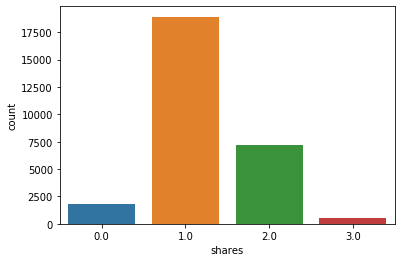

In [20]:
sns.countplot(x = 'shares', data=df)

In [30]:
#train = train.drop(['tweet_id','created_time','count','1','2','3','4','5','6','user_id','screen_name','title','content','url','expanded_url','created_datetime','max_retweets'], axis = 1)
#test = test.drop(['tweet_id','created_time','count','1','2','3','4','5','6','user_id','screen_name','title','content','url','expanded_url','created_datetime','max_retweets'], axis = 1)
train = train.drop(['full_text'],axis=1)
test = test.drop(['full_text'],axis=1)
test.head()

,Unnamed: 0,follower_count,title_len,content_len,is_mon,is_tue,is_wed,is_thu,is_fri,is_sat,...,The New York Times,NPR,TIME,U.S. News,USA TODAY,Fox News,Reuters,HuffPost,content_length,encoded
8,8,3634146.0,16,2826,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2837,"[[151, 1506, 1507, 748, 67, 30, 435, 2, 34, 35..."
14,14,14315833.0,8,1062,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1069,"[[2, 147, 3811, 86, 249, 1465, 1078, 1082, 105..."
26,28,7668571.0,15,999,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1014,"[[5043, 2, 3956, 458, 1879, 13, 2, 1763, 2552,..."
33,35,17862906.0,7,55,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,62,"[[865, 24254, 62, 7120, 4307, 67, 13386, 7120,..."
35,37,4102107.0,12,1619,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1626,"[[86, 303, 1156, 2, 3891, 2, 192, 764, 845, 21..."


In [19]:
X_train, y_train = list(train['encoded']), list(train['shares'])
X_valid, y_valid = list(test['encoded']), list(test['shares'])

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [26]:
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=6)

In [21]:
class NewsDataset(Dataset):
    def __init__(self, X, Y):
            self.X = X
            self.y = Y
            
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)).to(device), self.y[idx], self.X[idx][1]

In [22]:
train_ds = NewsDataset(X_train, torch.LongTensor(y_train))
valid_ds = NewsDataset(X_valid, torch.LongTensor(y_valid))

In [23]:
def get_class_distribution(obj):
    count_dict = {
        "0":0,
        "1":0,
        "2":0,
        "3":0
    }
    
    for i in obj:
        if i == 0:
            count_dict["0"] += 1
        elif i == 1:
            count_dict["1"] += 1
        elif i == 2:
            count_dict["2"] += 1
        else:
            count_dict["3"] += 1
    return count_dict

In [24]:
target_list = []

for _, t, s in train_ds:
    target_list.append(t)

target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [25]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)

print(class_weights)

tensor([6.9541e-04, 6.6573e-05, 1.7331e-04, 2.2727e-03])


In [26]:
class_weights_all = class_weights[target_list]

weighted_sampler = WeightedRandomSampler(
    weights = class_weights_all, 
    num_samples = len(class_weights_all),
    replacement = True
)

In [28]:
def train_model(model):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    for i in range(EPOCHS):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long().to(device)
            y = y.long().to(device)
            y_pred = model(x, l)
            optimizer.zero_grad()
            #loss = F.cross_entropy(y_pred, y)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item() *y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse, y_pred_list = validation_metrics(model, val_dl)
        if i%5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))
    print(classification_report(y_valid, y_pred_list))
def validation_metrics (model, valid_dl):
    #criterion = nn.CrossEntropyLoss(weight=class_weights.to("cpu"))
    zero_pred = 0
    one_pred = 0
    two_pred = 0
    three_pred =0
    zero = 0
    one = 0
    two = 0
    three = 0
    y_pred_list = list()
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long().to(device)
        y = y.long()
        #print(y)
        y_hat = model(x, l).cpu()
        loss = F.cross_entropy(y_hat, y)
        #loss = criterion(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        #y_pred_list.append(pred)
        #print("y", y, "pred: ", pred)
        for i in y:
            tmp = int(i.numpy())
            if tmp is 0:
                zero += 1
            elif tmp is 1:
                one += 1
            elif tmp is 2:
                two += 1
            else:
                three += 1
        for i in pred:
            tmp = int(i.numpy())
            y_pred_list.append(tmp)
            if tmp is 0:
                zero_pred += 1
            elif tmp is 1:
                one_pred += 1
            elif tmp is 2:
                two_pred += 1
            else:
                three_pred += 1
        correct += (pred == y).float().sum()
        total += y.shape[0]
        #print("correct: ", correct, " total: ", total)
        #print(classification_report(y, pred))
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    #print("pred: ", zero_pred, one_pred, two_pred, three_pred)
    #print("actual: ", zero, one, two, three)
    return sum_loss/total, correct/total, sum_rmse/total, y_pred_list

In [84]:
def train_model_regr(model):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    for i in range(EPOCHS):
        model.to("cuda:0")
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long().to(device)
            y = y.float().to(device)
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss = criterion(y_pred, y.long())
            #loss = F.mse_loss(y_pred, y.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            sum_loss += loss.item() *y.shape[0]
            total += y.shape[0]
        val_loss = validation_metrics_regr(model.to("cpu"), val_dl)
        if i%5 == 1:
            print("train mse %.3f, val rmse %.3f" % (sum_loss/total, val_loss))
def validation_metrics_regr (model, valid_dl):
    #criterion = nn.CrossEntropyLoss(weight=class_weights.to("cpu"))
    model.to("cpu")
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.float()
        y_hat = model(x.cpu(), l)
        loss =np.sqrt(F.mse_loss(y_hat, y.unsqueeze(-1)).item())
        #loss = criterion(y_hat, y)
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total

In [40]:
vocab_size = len(words)
#train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=weighted_sampler)
val_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [48]:
class LSTM_fixed_len(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True).to(device)
        self.linear = nn.Linear(hidden_dim, 4).to(device)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [28]:
class LSTM_variable_len(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 4)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [81]:
class LSTM_regr(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.2)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True).to(device)
        self.linear = nn.Linear(hidden_dim,1).to(device)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        out_pack, (ht, ct) = self.lstm(x)
        out = self.linear(ht[-1])
        return out

In [41]:
class LSTM_glove_vecs(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False ## freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 4)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [42]:
#model_fixed = LSTM_fixed_len(vocab_size, 50, 50).to(device)
#model_variable = LSTM_variable_len(vocab_size, 50, 50)
#model_reg = LSTM_regr(vocab_size, 50, 50).to(device)
model = LSTM_glove_vecs(vocab_size, 100, 100, pretrained_weights)

## Full title + content no punc [4 quantiles]

In [32]:
train_model(model_variable.to(device))

train loss 1.358, val loss 1.355, val accuracy 0.307, and val rmse 1.525
train loss 1.202, val loss 1.284, val accuracy 0.406, and val rmse 1.317
train loss 1.060, val loss 1.443, val accuracy 0.416, and val rmse 1.297
train loss 0.959, val loss 1.440, val accuracy 0.430, and val rmse 1.240
train loss 0.885, val loss 1.675, val accuracy 0.430, and val rmse 1.246
train loss 0.812, val loss 1.774, val accuracy 0.434, and val rmse 1.238
train loss 0.749, val loss 1.904, val accuracy 0.435, and val rmse 1.245
train loss 0.707, val loss 1.865, val accuracy 0.454, and val rmse 1.195
train loss 0.667, val loss 2.065, val accuracy 0.445, and val rmse 1.226
train loss 0.639, val loss 1.890, val accuracy 0.466, and val rmse 1.148
train loss 0.596, val loss 2.111, val accuracy 0.459, and val rmse 1.181
train loss 0.569, val loss 2.005, val accuracy 0.471, and val rmse 1.133
train loss 0.547, val loss 2.081, val accuracy 0.471, and val rmse 1.137
train loss 0.518, val loss 1.968, val accuracy 0.48

## title + content, no punc [log10 scale]

In [33]:
train_model(model_variable.to(device))

train loss 1.214, val loss 1.246, val accuracy 0.368, and val rmse 1.038
train loss 0.817, val loss 1.468, val accuracy 0.402, and val rmse 0.947
train loss 0.657, val loss 1.782, val accuracy 0.315, and val rmse 1.104
train loss 0.562, val loss 1.660, val accuracy 0.370, and val rmse 0.953
train loss 0.502, val loss 1.595, val accuracy 0.424, and val rmse 0.909
train loss 0.412, val loss 1.759, val accuracy 0.437, and val rmse 0.879
train loss 0.404, val loss 1.910, val accuracy 0.393, and val rmse 0.934
train loss 0.351, val loss 1.689, val accuracy 0.447, and val rmse 0.862
train loss 0.388, val loss 1.611, val accuracy 0.494, and val rmse 0.852
train loss 0.313, val loss 1.914, val accuracy 0.449, and val rmse 0.849
train loss 0.288, val loss 1.618, val accuracy 0.491, and val rmse 0.852
train loss 0.281, val loss 1.536, val accuracy 0.520, and val rmse 0.809
train loss 0.260, val loss 1.522, val accuracy 0.529, and val rmse 0.796
train loss 0.244, val loss 1.738, val accuracy 0.50

## title + content no punc, GloVe Embeddings

In [43]:
train_model(model.to(device))

train loss 1.322, val loss 1.348, val accuracy 0.387, and val rmse 1.128
train loss 1.139, val loss 1.288, val accuracy 0.471, and val rmse 0.941
train loss 1.018, val loss 1.261, val accuracy 0.516, and val rmse 0.894
train loss 0.958, val loss 1.189, val accuracy 0.552, and val rmse 0.776
train loss 0.883, val loss 1.252, val accuracy 0.534, and val rmse 0.817
train loss 0.841, val loss 1.168, val accuracy 0.588, and val rmse 0.735
train loss 0.859, val loss 1.228, val accuracy 0.545, and val rmse 0.777
train loss 0.793, val loss 1.185, val accuracy 0.587, and val rmse 0.732


RuntimeError: CUDA error: unspecified launch failure

## Full content + title (no punc) [4 quantiles] 

In [31]:
train_model(model_variable.to(device))

train loss 1.388, val loss 1.388, val accuracy 0.248, and val rmse 1.443
              precision    recall  f1-score   support

         0.0       0.25      0.08      0.12       660
         1.0       0.27      0.14      0.19       616
         2.0       0.23      0.55      0.33       620
         3.0       0.27      0.23      0.25       593

    accuracy                           0.25      2489
   macro avg       0.26      0.25      0.22      2489
weighted avg       0.26      0.25      0.22      2489

train loss 1.377, val loss 1.379, val accuracy 0.278, and val rmse 1.550
              precision    recall  f1-score   support

         0.0       0.32      0.34      0.33       660
         1.0       0.26      0.19      0.22       616
         2.0       0.25      0.27      0.26       620
         3.0       0.28      0.31      0.30       593

    accuracy                           0.28      2489
   macro avg       0.28      0.28      0.27      2489
weighted avg       0.28      0.28      

train loss 0.993, val loss 1.813, val accuracy 0.390, and val rmse 1.468
              precision    recall  f1-score   support

         0.0       0.40      0.79      0.53       660
         1.0       0.44      0.04      0.08       616
         2.0       0.40      0.06      0.11       620
         3.0       0.37      0.65      0.47       593

    accuracy                           0.39      2489
   macro avg       0.40      0.39      0.30      2489
weighted avg       0.40      0.39      0.30      2489

train loss 0.981, val loss 1.785, val accuracy 0.387, and val rmse 1.461
              precision    recall  f1-score   support

         0.0       0.45      0.69      0.55       660
         1.0       0.39      0.02      0.04       616
         2.0       0.32      0.06      0.10       620
         3.0       0.34      0.77      0.47       593

    accuracy                           0.39      2489
   macro avg       0.38      0.39      0.29      2489
weighted avg       0.38      0.39      

train loss 0.719, val loss 2.778, val accuracy 0.384, and val rmse 1.484
              precision    recall  f1-score   support

         0.0       0.38      0.82      0.52       660
         1.0       0.41      0.03      0.05       616
         2.0       0.33      0.03      0.06       620
         3.0       0.39      0.63      0.48       593

    accuracy                           0.38      2489
   macro avg       0.38      0.38      0.28      2489
weighted avg       0.38      0.38      0.28      2489

train loss 0.708, val loss 2.697, val accuracy 0.389, and val rmse 1.457
              precision    recall  f1-score   support

         0.0       0.40      0.79      0.53       660
         1.0       0.38      0.03      0.05       616
         2.0       0.33      0.05      0.08       620
         3.0       0.38      0.67      0.49       593

    accuracy                           0.39      2489
   macro avg       0.37      0.38      0.29      2489
weighted avg       0.37      0.39      

## Full content + title (kept punc, deleted non-common words) [4 quantiles]

In [25]:
train_model(model_variable.to(device))

train loss 1.389, val loss 1.386, val accuracy 0.266, and val rmse 1.492
              precision    recall  f1-score   support

         0.0       0.29      0.47      0.36       662
         1.0       0.24      0.51      0.32       622
         2.0       0.27      0.03      0.05       621
         3.0       0.44      0.04      0.07       611

    accuracy                           0.27      2516
   macro avg       0.31      0.26      0.20      2516
weighted avg       0.31      0.27      0.20      2516

train loss 1.373, val loss 1.377, val accuracy 0.277, and val rmse 1.556
              precision    recall  f1-score   support

         0.0       0.29      0.38      0.33       662
         1.0       0.25      0.29      0.27       622
         2.0       0.26      0.15      0.19       621
         3.0       0.31      0.27      0.29       611

    accuracy                           0.28      2516
   macro avg       0.28      0.28      0.27      2516
weighted avg       0.28      0.28      

train loss 1.042, val loss 1.792, val accuracy 0.333, and val rmse 1.565
              precision    recall  f1-score   support

         0.0       0.62      0.25      0.35       662
         1.0       0.33      0.04      0.07       622
         2.0       0.28      0.20      0.24       621
         3.0       0.30      0.86      0.45       611

    accuracy                           0.33      2516
   macro avg       0.38      0.34      0.28      2516
weighted avg       0.39      0.33      0.28      2516

train loss 1.008, val loss 1.917, val accuracy 0.327, and val rmse 1.616
              precision    recall  f1-score   support

         0.0       0.63      0.24      0.35       662
         1.0       0.42      0.04      0.07       622
         2.0       0.28      0.16      0.20       621
         3.0       0.29      0.89      0.44       611

    accuracy                           0.33      2516
   macro avg       0.40      0.33      0.26      2516
weighted avg       0.41      0.33      

train loss 0.757, val loss 2.701, val accuracy 0.348, and val rmse 1.572
              precision    recall  f1-score   support

         0.0       0.64      0.35      0.45       662
         1.0       0.55      0.03      0.05       622
         2.0       0.28      0.12      0.17       621
         3.0       0.30      0.91      0.45       611

    accuracy                           0.35      2516
   macro avg       0.44      0.35      0.28      2516
weighted avg       0.44      0.35      0.28      2516

train loss 0.733, val loss 2.782, val accuracy 0.347, and val rmse 1.580
              precision    recall  f1-score   support

         0.0       0.64      0.36      0.46       662
         1.0       0.55      0.03      0.05       622
         2.0       0.27      0.09      0.14       621
         3.0       0.30      0.92      0.45       611

    accuracy                           0.35      2516
   macro avg       0.44      0.35      0.27      2516
weighted avg       0.44      0.35      

## Full content + title (kept punc) [4 quantiles]

In [37]:
train_model(model_variable.to(device))

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 8.00 GiB total capacity; 4.50 GiB already allocated; 0 bytes free; 5.67 GiB reserved in total by PyTorch)